In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor

from utils import *

print(os.listdir('../input'))

['bluebook-for-bulldozers', 'bulldozerstmp']


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load dataset

In [4]:
os.makedirs('tmp', exist_ok=True)

TRAIN_PATH = './data/Train.csv'
VALID_PATH = './data/Valid.csv'
VALID_SOL = './data/ValidSolution.csv'
TEST_PATH = './data/Test.csv'

In [5]:
def display_all(df):
    with pd.option_context('display.max_rows', 100, 'display.max_columns', 1000):
        display(df)

In [6]:
# train_df = pd.read_csv(TRAIN_PATH, low_memory=False, parse_dates=['saledate'])
# valid_df = pd.read_csv(VALID_PATH, low_memory=False, parse_dates=['saledate'])
# valid_sol = pd.read_csv(VALID_SOL, low_memory=False)
# test_sol = pd.read_csv(TEST_PATH, low_memory=False, parse_dates=['saledate'])

In [7]:
# train_df.to_feather('tmp/train_raw')
# valid_df.to_feather('tmp/valid_raw')
# valid_sol.to_feather('tmp/valid_sol_raw')
# test_sol.to_feather('tmp/test_raw')

### Merge valid data

In [8]:
# valid_df = pd.read_feather('tmp/valid_raw')
# valid_sol = pd.read_feather('tmp/valid_sol_raw')

# valid_df = pd.merge(left=valid_df, right=valid_sol, how='left', left_on='SalesID', right_on='SalesID')
# valid_df.drop('Usage', axis=1, inplace=True)

# valid_df.to_feather('tmp/valid_raw')

In [9]:
train_df = pd.read_feather('../input/bulldozerstmp/train_raw')
train_temp_df = train_df.copy()
valid_df = pd.read_feather('../input/bulldozerstmp/valid_raw')
valid_temp_df = valid_df.copy()

print(len(train_df))
print(len(valid_df))

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


401125
11573


In [10]:
%time add_datecols(train_df, col='saledate')
%time add_datecols(valid_df, col='saledate')

CPU times: user 544 ms, sys: 140 ms, total: 684 ms
Wall time: 682 ms
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 23.6 ms


In [11]:
def get_n_unique(df):
    for col in df.columns:
        print(f'{col}: {len(df[col].unique())}')

# get_n_unique(train_df)

In [12]:
# Replace None and other null values with np.nan
nan_cols = [None, 'None or Unspecified', 'None', 'NaN', 'nan']
replace_nan(train_df, nan_cols)
replace_nan(valid_df, nan_cols)

In [16]:
drop_cols = None
cat_cols = ['Tire_Size', 'UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls']
cont_cols = ['SalesID', 'MachineHoursCurrentMeter', 'auctioneerID', 'MachineID', 'ModelID', 'datasource', 'YearMade']

In [17]:
# Convert y to log values
train_df['SalePrice'] = np.log(train_df['SalePrice'])
valid_df['SalePrice'] = np.log(valid_df['SalePrice'])

In [18]:
# Convert categorical data to categoriy dtype and continous data to float32 dtype
conv_contncat(train_df, cont_cols, cat_cols)
conv_contncat(valid_df, cont_cols, cat_cols)

In [19]:
# Fill missing values
na_dict = fix_missing(train_df, None, cont_cols, cat_cols)
na_dict = fix_missing(valid_df, na_dict, cont_cols, cat_cols)
# cat_cols.extend([col for col in train_df.columns if col.endswith('_na')])

In [20]:
# Get mappers
cat_mapper, cont_mapper = get_nn_mappers(train_df, cat_cols, cont_cols)

In [21]:
# Proc_df
%time X_train, y_train = proc_df(train_df, 'SalePrice', drop_cols=drop_cols, cat_mapper=cat_mapper, cont_mapper=cont_mapper)

CPU times: user 10.9 s, sys: 2.66 s, total: 13.5 s
Wall time: 13.6 s


In [22]:
%time X_valid, y_valid = proc_df(valid_df, 'SalePrice', drop_cols=drop_cols, cat_mapper=cat_mapper, cont_mapper=cont_mapper)

CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 312 ms


In [23]:
X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)

In [24]:
def rmse(y_pred, y_true):
    return np.mean((y_pred - y_true)**2) ** 0.5

def get_scores(m, X_train, y_train, X_valid, y_valid):
    scores = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), m.score(X_train, y_train), m.score(X_valid, y_valid)]

    if m.oob_score is True:
        scores.append(m.oob_score_)

    return scores

In [30]:
m2 = RandomForestRegressor(n_estimators = 40, n_jobs=-1, oob_score=True)
%time m2.fit(X_train, y_train)
%time get_scores(m2, X_train, y_train, X_valid, y_valid)

CPU times: user 6min 52s, sys: 2.74 s, total: 6min 55s
Wall time: 3min 33s
CPU times: user 13.5 s, sys: 212 ms, total: 13.7 s
Wall time: 7.28 s


[0.07944135612262798,
 0.25682130754101945,
 0.9868825304056412,
 0.8777168667723875,
 0.906483149008303]

In [31]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
%time get_scores(m, X_train, y_train, X_valid, y_valid)

CPU times: user 13min 38s, sys: 4.71 s, total: 13min 43s
Wall time: 7min 3s
CPU times: user 26.8 s, sys: 68 ms, total: 26.9 s
Wall time: 14 s


[0.07714858049865315,
 0.2547792179257007,
 0.9876287766728782,
 0.8796537802949524,
 0.9103557034171499]

In [25]:
m3 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
%time m3.fit(X_train, y_train)
%time get_scores(m3, X_train, y_train, X_valid, y_valid)

CPU times: user 4min 42s, sys: 2.06 s, total: 4min 44s
Wall time: 2min 27s
CPU times: user 13.9 s, sys: 368 ms, total: 14.3 s
Wall time: 7.79 s


[0.11974766408355328,
 0.2442236615921707,
 0.9701948804310419,
 0.8894191487031452,
 0.9113431058541983]

## Feature importances

In [26]:
fi = rf_feat_importance(m3, X_train)

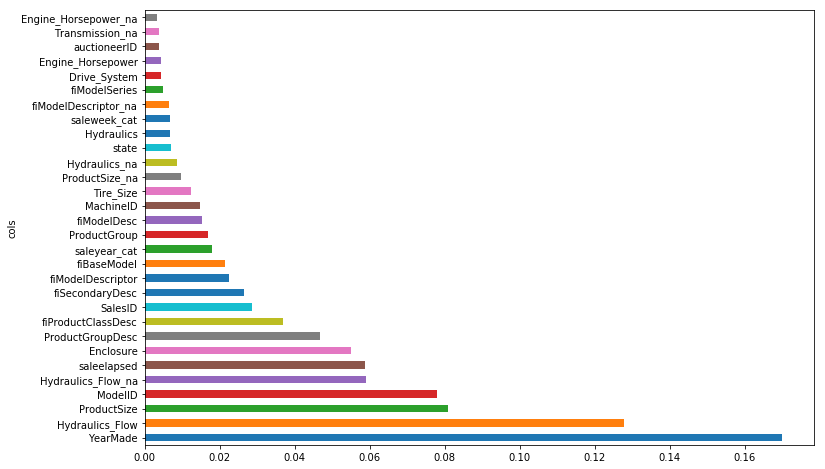

In [27]:
fi[:30].plot('cols', 'imp', 'barh', figsize=(12, 8), legend=False)

In [28]:
cols_to_keep = fi[fi['imp'] > 0.005]['cols']
len(cols_to_keep)

24

In [29]:
X_train_keep = X_train[cols_to_keep].copy()
X_valid_keep = X_valid[cols_to_keep].copy()

In [32]:
m4 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
%time m4.fit(X_train_keep, y_train)
%time get_scores(m4, X_train_keep, y_train, X_valid_keep, y_valid)

CPU times: user 2min 32s, sys: 420 ms, total: 2min 33s
Wall time: 1min 19s
CPU times: user 12.3 s, sys: 112 ms, total: 12.5 s
Wall time: 6.65 s


[0.12576728896010084,
 0.24470638980434045,
 0.9671230011566576,
 0.8889815723292935,
 0.9087701413414087]

## Removing redundant features

In [33]:
import scipy
from scipy.cluster import hierarchy as hc

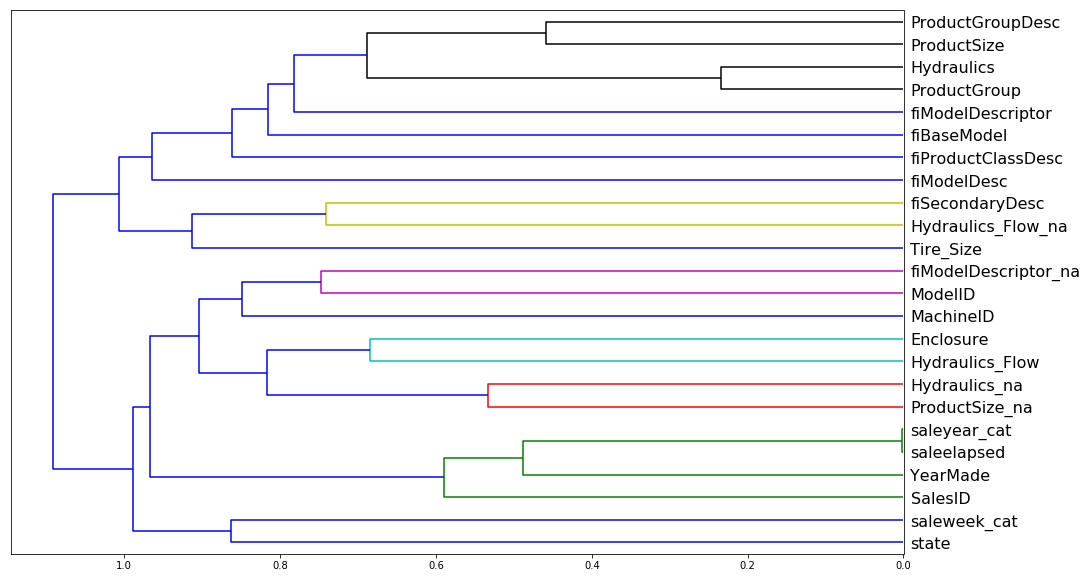

In [34]:
corr = np.round(scipy.stats.spearmanr(X_train_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [36]:
dn_cols = ['saleyear_cat', 'saleelapsed']

for col in dn_cols:
    X_train_temp = X_train_keep.drop(col, axis=1).copy()
    X_valid_temp = X_valid_keep.drop(col, axis=1).copy()
    m = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.6, oob_score=True)
    m.fit(X_train_temp, y_train)
    print(col)
    print(get_scores(m, X_train_temp, y_train, X_valid_temp, y_valid))

saleyear_cat
[0.12693797674434162, 0.2460503782308987, 0.9665080903212674, 0.8877587417823184, 0.9080691883344022]
saleelapsed
[0.13037286338051912, 0.24590188579563094, 0.9646710137490815, 0.8878941770423215, 0.9060558516725439]


## Extrapolation

In [51]:
X_train_ext = X_train_keep.copy()
X_valid_ext = X_valid_keep.copy()
X_train_ext['is_valid'] = 0
X_valid_ext['is_valid'] = 1
X_ext = pd.concat([X_train_ext, X_valid_ext], ignore_index=True)
X_ext = X_ext.sample(frac=1).reset_index(drop=True)

y_ext = X_ext['is_valid']
X_ext.drop('is_valid', axis=1, inplace=True)

X_ext.head()

,YearMade,Hydraulics_Flow,ProductSize,ModelID,Hydraulics_Flow_na,saleelapsed,Enclosure,ProductGroupDesc,fiProductClassDesc,SalesID,fiSecondaryDesc,fiModelDescriptor,fiBaseModel,saleyear_cat,ProductGroup,fiModelDesc,MachineID,Tire_Size,ProductSize_na,Hydraulics_na,state,Hydraulics,saleweek_cat,fiModelDescriptor_na
0,1977.0,0.0,0.0,8089.0,1.0,6.079968e+17,4.0,1.0,22.0,1595078.0,0.0,0.0,1840.0,1989.0,1.0,3676.0,1281835.0,0.0,1.0,1.0,30.0,0.0,14.0,1.0
1,1000.0,0.0,4.0,2768.0,1.0,1.243382e+18,4.0,6.0,62.0,2261955.0,154.0,0.0,1080.0,2009.0,3.0,3006.0,16019.0,0.0,0.0,0.0,14.0,1.0,22.0,1.0
2,1983.0,0.0,0.0,4954.0,1.0,7.922880e+17,4.0,5.0,64.0,1657753.0,81.0,0.0,1853.0,1995.0,5.0,4451.0,1282684.0,0.0,1.0,0.0,14.0,1.0,6.0,1.0
3,2003.0,0.0,1.0,14272.0,1.0,1.141776e+18,3.0,4.0,65.0,1602792.0,67.0,13.0,1176.0,2006.0,6.0,2501.0,1140248.0,0.0,0.0,0.0,10.0,10.0,10.0,0.0
4,1000.0,0.0,2.0,4675.0,1.0,1.091059e+18,1.0,4.0,37.0,1582896.0,96.0,0.0,342.0,2004.0,6.0,2178.0,674131.0,0.0,0.0,0.0,5.0,6.0,31.0,1.0


In [38]:
m6 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.6, oob_score=True)
%time m6.fit(X_ext, y_ext)
print(m6.oob_score_)

CPU times: user 11.8 s, sys: 4 ms, total: 11.8 s
Wall time: 11.8 s
0.9999936507880285


In [39]:
ft_ext = rf_feat_importance(m6, X_ext)
ft_ext[:10]

,cols,imp
13,saleyear_cat,0.530069
5,saleelapsed,0.403296
9,SalesID,0.045869
22,saleweek_cat,0.012414
16,MachineID,0.008262
3,ModelID,0.000089
0,YearMade,0.000000
14,ProductGroup,0.000000
21,Hydraulics,0.000000
20,state,0.000000


In [52]:
t_feats = ['saleyear_cat', 'saleelapsed', 'SalesID', 'saleweek_cat', 'MachineID']

In [53]:
X_ext.drop(t_feats, axis=1, inplace=True)

In [54]:
m6 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.6, oob_score=True)
%time m6.fit(X_ext, y_ext)
print(m6.oob_score_)

CPU times: user 1min 5s, sys: 48 ms, total: 1min 5s
Wall time: 1min 5s
0.11372066660180824


In [44]:
m7 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.6, oob_score=True)
%time m7.fit(X_train_keep, y_train)
get_scores(m7, X_train_keep, y_train, X_valid_keep, y_valid)

CPU times: user 1min 43s, sys: 168 ms, total: 1min 43s
Wall time: 1min 43s


[0.12600394094985348,
 0.24500323274921845,
 0.9669991577102367,
 0.8887120654708024,
 0.9084370330255321]

In [55]:
for col in t_feats:
    X_train_temp = X_train_keep.drop(col, axis=1)
    X_valid_temp = X_valid_keep.drop(col, axis=1)
    
    m0 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.6, oob_score=True)
    m0.fit(X_train_temp, y_train)
    print(col)
    print(get_scores(m0, X_train_temp, y_train, X_valid_temp, y_valid))

saleyear_cat
[0.1270074778827065, 0.24639859853930632, 0.9664714052700766, 0.8874408203636502, 0.907850436494885]
saleelapsed
[0.13046597119885883, 0.24516145080495666, 0.9646205342345779, 0.8885682841353821, 0.9062035415385199]
SalesID
[0.1305634169144763, 0.24345144563067125, 0.964567664281827, 0.8901173390094772, 0.9084944704800096]
saleweek_cat
[0.1296792370132768, 0.24874008053429233, 0.965045937304982, 0.8852913961903017, 0.9077434696508947]
MachineID
[0.12997772302051855, 0.2440039716824443, 0.9648848428052603, 0.8896180038881556, 0.9101098902189805]


## Final random-forest regressor

In [57]:
X_train_temp = X_train_keep.drop(['SalesID', 'MachineID'], axis=1)
X_valid_temp = X_valid_keep.drop(['SalesID', 'MachineID'], axis=1)

m9 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.6, oob_score=True)
%time m9.fit(X_train_temp, y_train)
%time get_scores(m9, X_train_temp, y_train, X_valid_temp, y_valid)

CPU times: user 1min 10s, sys: 100 ms, total: 1min 11s
Wall time: 1min 11s
CPU times: user 9.56 s, sys: 4 ms, total: 9.56 s
Wall time: 9.57 s


[0.13570501824775388,
 0.24261294549789278,
 0.961722057723292,
 0.8908729554423678,
 0.9102475329321587]

In [58]:
X_train_temp.columns

Index(['YearMade', 'Hydraulics_Flow', 'ProductSize', 'ModelID',
       'Hydraulics_Flow_na', 'saleelapsed', 'Enclosure', 'ProductGroupDesc',
       'fiProductClassDesc', 'fiSecondaryDesc', 'fiModelDescriptor',
       'fiBaseModel', 'saleyear_cat', 'ProductGroup', 'fiModelDesc',
       'Tire_Size', 'ProductSize_na', 'Hydraulics_na', 'state', 'Hydraulics',
       'saleweek_cat', 'fiModelDescriptor_na'],
      dtype='object')

In [62]:
X_train_final = X_train_keep.drop(['MachineID', 'SalesID'], axis=1)
X_valid_final = X_valid_keep.drop(['MachineID', 'SalesID'], axis=1)

m9 = RandomForestRegressor(n_estimators=160, min_samples_leaf = 3, max_features=0.5, oob_score=True)
%time m9.fit(X_train_final, y_train)
%time get_scores(m9, X_train_final, y_train, X_valid_final, y_valid)

CPU times: user 3min 16s, sys: 744 ms, total: 3min 16s
Wall time: 3min 16s
CPU times: user 31.8 s, sys: 12 ms, total: 31.8 s
Wall time: 31.9 s


[0.13737117410878166,
 0.2415431155406774,
 0.9607763515337748,
 0.8918332502494163,
 0.9126637329644186]